### Росбанк соревнование на boosters.

Задачи:
    - Предсказание оттока. Бинарная классификация. Метрика AUC.
    - Предсказание суммы POS транзакций в последцющие 3 месяца для клиентов. Метрика - MSE на логарифмах

In [101]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt


from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [2]:
# PERIOD is parsed, 'TRDATETIME' - not
train = pd.read_csv('train.csv', parse_dates = ['PERIOD'])
test =  pd.read_csv('test.csv', parse_dates = ['PERIOD'])

In [3]:
print(train.head(), "\n")
print(test.head())

      PERIOD  cl_id   MCC channel_type  currency        TRDATETIME   amount  \
0 2017-01-10      0  5200          NaN       810  21OCT17:00:00:00   5023.0   
1 2017-01-10      0  6011          NaN       810  12OCT17:12:24:07  20000.0   
2 2017-01-12      0  5921          NaN       810  05DEC17:00:00:00    767.0   
3 2017-01-10      0  5411          NaN       810  21OCT17:00:00:00   2031.0   
4 2017-01-10      0  6012          NaN       810  24OCT17:13:14:24  36562.0   

  trx_category  target_flag  target_sum  
0          POS            0         0.0  
1      DEPOSIT            0         0.0  
2          POS            0         0.0  
3          POS            0         0.0  
4      C2C_OUT            0         0.0   

      PERIOD  cl_id   MCC channel_type  currency        TRDATETIME  amount  \
0 2017-01-04      2  5814          NaN       810  18APR17:00:00:00  153.00   
1 2017-01-03      2  5812          NaN       810  10MAR17:00:00:00  388.08   
2 2017-01-02      2  5691          Na

In [6]:
#tmp.sort_values('amount', ascending=False)

In [4]:
np.log(train['amount']+1).hist(bins=50);

In [5]:
np.log(test['amount'] + 1).hist(bins=50);

Outliyers!

In [6]:
#train['channel_type'].value_counts()

In [7]:
#train['trx_category'].value_counts()

In [73]:
print(train.shape)
print(test.shape, "\n")
print(len(np.unique(train['cl_id'])))
print(len(np.unique(test['cl_id'])))

(490513, 10)
(518376, 8) 

5000
5217


In [ ]:
# target для всех клиентов одинаковый, это хорошо

In [9]:
print( set(train['cl_id']).intersection(set(test['cl_id'])) )

set()


In [10]:
train.head(2)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,2017-01-10,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,2017-01-10,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0


In [11]:
test.head(2)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category
0,2017-01-04,2,5814,NaN,810,18APR17:00:00:00,153.00,POS
1,2017-01-03,2,5812,NaN,810,10MAR17:00:00:00,388.08,POS


Приводим дату к нормальному формату

In [12]:
train = train.assign(year = pd.DatetimeIndex(train['PERIOD']).year.values, 
                     month = pd.DatetimeIndex(train['PERIOD']).month.values,
                     day =   train['TRDATETIME'].apply(lambda x: x[:2]))

train = train.assign( txn_dt = 
                     pd.to_datetime(train['year'].astype(str) + '-' \
                                    + train['month'].astype(str) + '-' + train['day'].astype(str)))
#train.drop(['year', 'month', 'day'], axis=1, inplace=True)
train.drop(['day'], axis=1, inplace=True)

test = test.assign(year = pd.DatetimeIndex(test['PERIOD']).year.values, 
                     month = pd.DatetimeIndex(test['PERIOD']).month.values,
                     day =   test['TRDATETIME'].apply(lambda x: x[:2]))

test = test.assign( txn_dt = 
                     pd.to_datetime(test['year'].astype(str) + '-' \
                                    + test['month'].astype(str) + '-' + test['day'].astype(str)))
#test.drop(['year', 'month', 'day'], axis=1, inplace=True)
test.drop(['day'], axis=1, inplace=True)

In [13]:
train.head(2)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,month,year,txn_dt
0,2017-01-10,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0,1,2017,2017-01-21
1,2017-01-10,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0,1,2017,2017-01-12


In [14]:
# list of fields to group by :
#group_by_fields = ['MCC', 'channel_type', 'currency', 'trx_category']
# add window_list:
# START_DATE 
# window_list = [30, 90, 180, all]
def get_aggr_feat(df,  group_by_fields, 
                 id_field = 'cl_id', 
                 value = 'amount', 
                 func_list = ['sum', 'std', 'max', 'min', 'count']):
    
    df_out = pd.DataFrame(df[id_field].unique())
    df_out.columns = [id_field]
      
    for field in group_by_fields:
        df_tmp = df.groupby([id_field, field])[value].agg(func_list).reset_index()                               
        df_tmp = df_tmp.pivot_table(index=id_field ,columns=field)
        field_idx = df_tmp.columns.get_level_values(0)
        func_idx = df_tmp.columns.get_level_values(1)
        if ( type( field_idx[0]) != str):
             field_idx = field_idx.astype(str)
        if ( type( func_idx[0]) != str):
             func_idx = func_idx.astype(str)       
        col_names_list = [ field_idx[i] + '_' + func_idx[i]
                           for i in range(df_tmp.shape[1])]
        df_tmp.columns = col_names_list
        df_tmp = df_tmp.reset_index()
        df_out = df_out.merge(df_tmp, on = id_field, how='left') 
        
    return df_out
        # add date window aggr 
        # add count distinct values 

In [19]:
train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,month,year,txn_dt
0,2017-01-10,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0,1,2017,2017-01-21
1,2017-01-10,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0,1,2017,2017-01-12
2,2017-01-12,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0,1,2017,2017-01-05
3,2017-01-10,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0,1,2017,2017-01-21
4,2017-01-10,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0,1,2017,2017-01-24


In [52]:
# reduce MCC number: take only most popular:
top_mcc = train[['MCC', 'amount']].groupby('MCC')['amount'].agg(['sum', 'count']).reset_index()

# Can validate n_top as parametr
n_top = 20
top_mcc_sum = top_mcc.sort_values('sum', ascending=False)['MCC'].values[0:n_top]
top_mcc_count = top_mcc.sort_values('count', ascending=False)['MCC'].values[0:n_top]
print(top_mcc_sum, "\n")
print(top_mcc_count, "\n")
top_mcc = set(top_mcc_sum.tolist() + top_mcc_count.tolist())
print(len(top_mcc))

[6011 6012 5411 7011 4829 5812 4722 5712 5211 4511 5722 5732 5541 5691 5999
 5499 4812 5814 5261 3011] 

[5411 6011 5814 5812 5499 5541 5912 5999 6012 5921 5331 4121 5211 4829 5691
 5261 4111 5977 5200 5732] 

27


In [65]:
# reduce MCC number:
train['MCC'] = train['MCC'].apply(lambda x : x if x in top_mcc else -1)
test['MCC'] = test['MCC'].apply(lambda x : x if x in top_mcc else -1)

In [67]:
train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,month,year,txn_dt
0,2017-01-10,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0,1,2017,2017-01-21
1,2017-01-10,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0,1,2017,2017-01-12
2,2017-01-12,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0,1,2017,2017-01-05
3,2017-01-10,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0,1,2017,2017-01-21
4,2017-01-10,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0,1,2017,2017-01-24


In [72]:
%%time
X_tr = get_aggr_feat(df=train, 
                     group_by_fields = ['MCC', 'channel_type', 'currency', 
                                        'trx_category', 'year', 'month'],
                     id_field = 'cl_id',
                     value = 'amount', 
                     func_list = ['sum', 'max', 'min', 'count'])

X_ts = get_aggr_feat(df=test, 
                     group_by_fields = ['MCC', 'channel_type', 'currency', 
                                        'trx_category', 'year', 'month'],
                     id_field = 'cl_id',
                     value = 'amount', 
                     func_list = ['sum', 'max', 'min', 'count'])

Wall time: 2.28 s


In [70]:
X_tr.head(2)

,cl_id,count_-1,count_3011,count_4111,count_4121,count_4511,count_4722,count_4812,count_4829,count_5200,...,min_2016,min_2017,min_2018,sum_2016,sum_2017,sum_2018,count_1,max_1,min_1,sum_1
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,767.0,NaN,NaN,64383.00,NaN,5,36562.0,767.0,64383.00
1,1,16.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,3.0,NaN,NaN,267578.04,NaN,104,60000.0,3.0,267578.04


In [74]:
X_ts.head(2)

,cl_id,count_-1,count_3011,count_4111,count_4121,count_4511,count_4722,count_4812,count_4829,count_5200,...,min_2016,min_2017,min_2018,sum_2016,sum_2017,sum_2018,count_1,max_1,min_1,sum_1
0,2,40.0,2.0,11.0,NaN,NaN,NaN,1.0,2.0,NaN,...,NaN,8.0,NaN,NaN,328717.72,NaN,199,20000.0,8.0,328717.72
1,3,9.0,NaN,2.0,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,42.0,NaN,NaN,270848.77,NaN,96,45000.0,42.0,270848.77


In [75]:
print(X_tr.shape, "\n")
print(X_ts.shape, "\n")

(5000, 425) 

(5217, 429) 



In [ ]:
# Need same columns
# Why this happend? - 

In [115]:
# get NaN percent in each column in train:
def feat_nan_perc(col):
    return round( col.isnull().sum() / len(col), 3);  

NaN_perc_tr = X_tr.apply(feat_nan_perc, axis=0)
NaN_perc_ts = X_ts.apply(feat_nan_perc, axis=0)

In [142]:
#NaN_perc_tr.hist();

In [143]:
print( np.sum(NaN_perc_tr.values < 0.7), "\n")
print( np.sum(NaN_perc_ts.values < 0.7))

97 

97


In [159]:
# RUN only one time!
#NaN_feat = NaN_perc_tr.values < 0.7
#X_tr = X_tr.iloc[:,np.where(NaN_feat)[0]]

In [161]:
X_ts.shape

(5217, 97)

In [163]:
print( set(X_tr.columns.values) - set(X_ts.columns.values), "\n")
print( set(X_ts.columns.values) - set(X_tr.columns.values), "\n")

set() 

set() 



In [169]:
train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,month,year,txn_dt
0,2017-01-10,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0,1,2017,2017-01-21
1,2017-01-10,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0,1,2017,2017-01-12
2,2017-01-12,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0,1,2017,2017-01-05
3,2017-01-10,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0,1,2017,2017-01-21
4,2017-01-10,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0,1,2017,2017-01-24


In [184]:
train_data = X_tr.merge( 
    train[['cl_id', 'target_flag']].groupby(['cl_id'])[['target_flag']].mean().reset_index(), 
    how='inner', on='cl_id')

In [185]:
train_data.head()

,cl_id,count_-1,count_5331,count_5411,count_5499,count_5541,count_5691,count_5812,count_5814,count_5912,...,max_2017,min_2016,min_2017,sum_2016,sum_2017,count_1,max_1,min_1,sum_1,target_flag
0,0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,36562.00,NaN,767.0,NaN,64383.00,5,36562.00,767.0,64383.00,0
1,1,16.0,NaN,12.0,2.0,NaN,3.0,19.0,41.0,3.0,...,60000.00,NaN,3.0,NaN,267578.04,104,60000.00,3.0,267578.04,0
2,5,38.0,2.0,31.0,8.0,NaN,13.0,2.0,1.0,3.0,...,56164.05,NaN,8.2,NaN,546369.13,142,56164.05,8.2,546369.13,1
3,9,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,117450.00,NaN,39.0,NaN,849315.09,39,117450.00,39.0,849315.09,0
4,10,46.0,27.0,103.0,30.0,22.0,NaN,2.0,4.0,20.0,...,150000.00,NaN,3.0,NaN,1124343.99,463,150000.00,3.0,1124343.99,0


In [186]:
train_data['target_flag'].value_counts()

1    2767
0    2233
Name: target_flag, dtype: int64

### MODELING

In [272]:
%%time
# set params
my_xgb_estimator = xgb.XGBClassifier(max_depth=2, 
                                   n_estimators=100,
                                   learning_rate=0.1,
                                   #min_child_weight=4,
                                   #col_sample_bytree=0.8,
                                   #subsample=0.7,
                                   #reg_alpha=1,
                                   #reg_gamma=1,
                                   #scale_pos_weight=1,
                                   objective='binary:logistic',
                                   #eval_metric='auc',
                                   seed=42
                                   )
score = np.mean(cross_val_score(estimator=my_xgb_estimator, 
                                X=train_data.drop(['target_flag'],axis=1).values,
                                y=train_data['target_flag'].values,
                                scoring='roc_auc', cv=5))
print('{:.4f}'.format(score), "\n")

0.2863 

Wall time: 8.83 s


In [273]:
set(X_ts.columns.tolist()) - set(train_data.columns.tolist()) 

set()

In [274]:
set(train_data.columns.tolist()) - set(X_ts.columns.tolist()) 

{'target_flag'}

In [247]:
%%time
# model:
xgb_model = xgb.XGBClassifier(max_depth=6, 
                                   n_estimators=500,
                                   learning_rate=0.01,
                                   #min_child_weight=4,
                                   #col_sample_bytree=0.8,
                                   #subsample=0.7,
                                   #reg_alpha=1,
                                   #reg_gamma=1,
                                   #scale_pos_weight=1,
                                   objective='binary:logistic',
                                   eval_metric='auc',
                                   seed=42
                                   )

xgb_model.fit(train_data.drop(['target_flag'],axis=1).values, 
                       train_data['target_flag'].values)

pred_tr = xgb_model.predict_proba(train_data.drop(['target_flag'],axis=1).values)[:,1]
pred_ts = xgb_model.predict_proba(X_ts.values)[:,1]

In [248]:
#pred_tr.hist(bins=100, color='red');

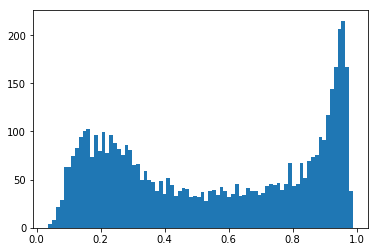

In [249]:
plt.hist(pred_tr, bins=80);

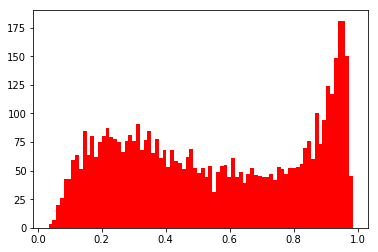

In [250]:
plt.hist(pred_ts, bins=80, color='red');

In [251]:
print(pred_tr.mean(), "\n")
print(train_data['target_flag'].mean())

0.552937 

0.5534


In [262]:
def submit(ids, preds):
    out_df = pd.DataFrame( data = np.vstack((ids, preds)).T,
                           columns = ['_ID_','_VAL_'])
    return out_df

In [271]:
X_ts['cl_id'].values

array([    2,     3,     4, ..., 10209, 10211, 10216], dtype=int64)

In [ ]:
np.vstack((X_ts['cl_id'].values, preds)).T

In [270]:
# write answer:
submit(X_ts['cl_id'].values, pred_ts).to_csv('submits/xgb_first_submit.csv', index=False)

In [ ]:
# 0.81